In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append('../../Share/')
sys.path.append('../')
import self_supervised_v1
import baseline#, config
import config

import warnings
warnings.filterwarnings('ignore')

def plot_result(result):
    plt.figure(figsize=(10, 5))
    plt.plot(result.history['accuracy'], label='accuracy', marker='o')
    plt.plot(result.history['val_accuracy'], label='val_accuracy', marker='o')
    plt.title('Pre-training Stage')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()



SUBJECT = "Hunmin"
trainer = baseline.ModelTrainer(config, subject=SUBJECT)
trainer_Carlson = baseline.ModelTrainer(config, subject="Carlson")
trainer_Harold = baseline.ModelTrainer(config, subject="Harold")
#trainer_Hunmin = baseline.ModelTrainer(config, subject="Hunmin")
trainer_Brian = baseline.ModelTrainer(config, subject="Brian")
trainer_Xianyu = baseline.ModelTrainer(config, subject="Xianyu")

Dataset 1/66 - Session Exp_2025-05-27/E8331D05289A/


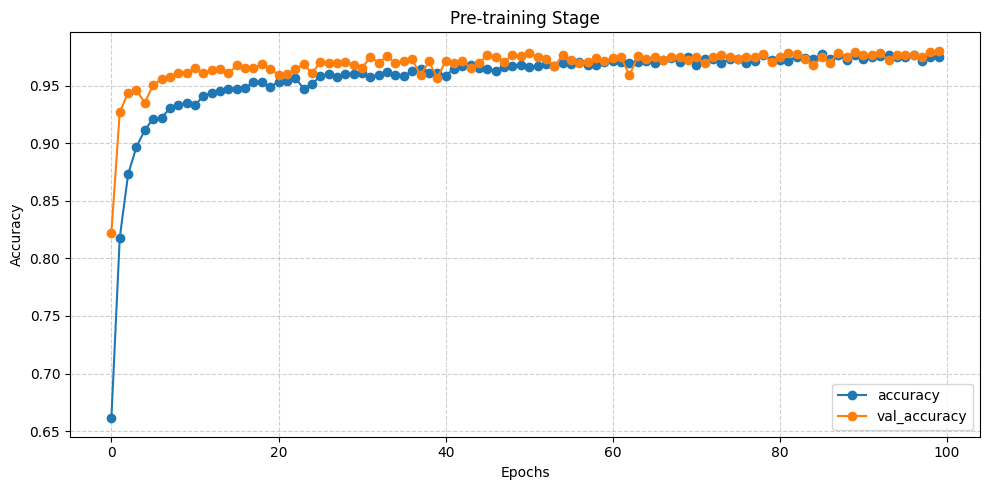

Dataset 1/66 - Session Exp_2025-05-27/E8331D05289A/
Dataset 2/66 - Session Exp_2025-06-18/E9AD0E7DCC2B/


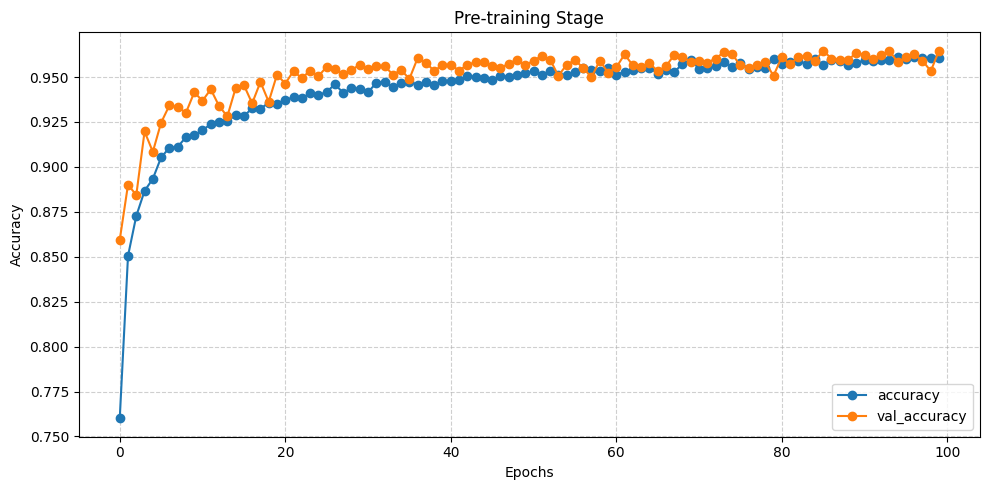

Dataset 1/66 - Session Exp_2025-05-27/E8331D05289A/
Dataset 2/66 - Session Exp_2025-06-18/E9AD0E7DCC2B/
Dataset 3/66 - Session Exp_2025-06-20-v1/E9AD0E7DCC2B/
Dataset 4/66 - Session Exp_2025-06-20-v2/E9AD0E7DCC2B/


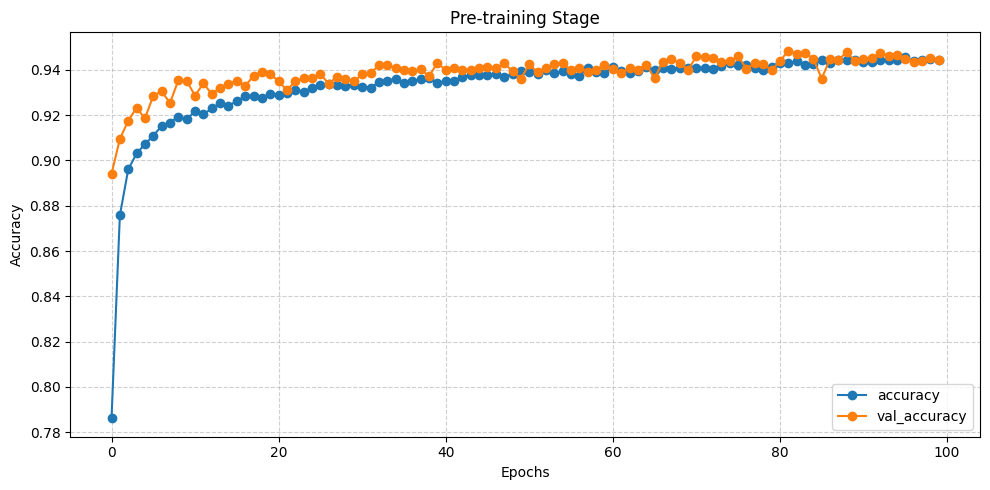

Dataset 1/66 - Session Exp_2025-05-27/E8331D05289A/
Dataset 2/66 - Session Exp_2025-06-18/E9AD0E7DCC2B/
Dataset 3/66 - Session Exp_2025-06-20-v1/E9AD0E7DCC2B/
Dataset 4/66 - Session Exp_2025-06-20-v2/E9AD0E7DCC2B/
Dataset 5/66 - Session Exp_2025-06-20-v3/E9AD0E7DCC2B/
Dataset 6/66 - Session Exp_2025-06-20-v4/E9AD0E7DCC2B/


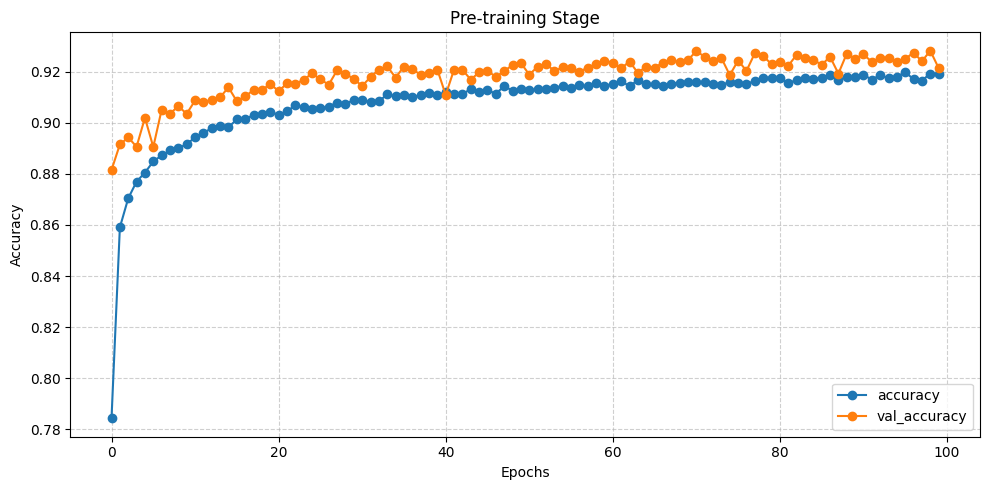

In [2]:
Threshold_K = 1  # 초기 학습 데이터
X_init, y_init, X_init_test, y_init_test = trainer.return_until_K_data(K=Threshold_K, train_ratio=0.8)
model = self_supervised_v1.build_model()  # 모델 생성 및 초기 학습
result = model.fit(X_init, y_init, validation_data=(X_init_test, y_init_test), epochs=100, batch_size=64, verbose=0)
plot_result(result)
model.save('./model_K1.h5')


Threshold_K = 2  # 초기 학습 데이터
X_init, y_init, X_init_test, y_init_test = trainer.return_until_K_data(K=Threshold_K, train_ratio=0.8)
model = self_supervised_v1.build_model()  # 모델 생성 및 초기 학습
result = model.fit(X_init, y_init, validation_data=(X_init_test, y_init_test), epochs=100, batch_size=64, verbose=0)
plot_result(result)
model.save('./model_K2.h5')

Threshold_K = 4  # 초기 학습 데이터
X_init, y_init, X_init_test, y_init_test = trainer.return_until_K_data(K=Threshold_K, train_ratio=0.8)
model = self_supervised_v1.build_model()  # 모델 생성 및 초기 학습
result = model.fit(X_init, y_init, validation_data=(X_init_test, y_init_test), epochs=100, batch_size=64, verbose=0)
plot_result(result)
model.save('./model_K4.h5')

Threshold_K = 6  # 초기 학습 데이터
X_init, y_init, X_init_test, y_init_test = trainer.return_until_K_data(K=Threshold_K, train_ratio=0.8)
model = self_supervised_v1.build_model()  # 모델 생성 및 초기 학습
result = model.fit(X_init, y_init, validation_data=(X_init_test, y_init_test), epochs=100, batch_size=64, verbose=0)
plot_result(result)
model.save('./model_K6.h5')

Dataset 1/58 - Session Exp_2025-05-27/E8331D05289A/
Dataset 2/58 - Session Exp_2025-06-18/E9AD0E7DCC2B/
Dataset 3/58 - Session Exp_2025-06-20-v1/E9AD0E7DCC2B/
Dataset 4/58 - Session Exp_2025-06-20-v2/E9AD0E7DCC2B/
Dataset 5/58 - Session Exp_2025-06-20-v3/E9AD0E7DCC2B/
Dataset 6/58 - Session Exp_2025-06-20-v4/E9AD0E7DCC2B/
Dataset 7/58 - Session Exp_2025-06-20-v5/E9AD0E7DCC2B/
Dataset 8/58 - Session Exp_2025-06-20-v6/E9AD0E7DCC2B/
Dataset 9/58 - Session Exp_2025-06-20-v7/E9AD0E7DCC2B/
Dataset 10/58 - Session Exp_2025-06-20-v8/E9AD0E7DCC2B/


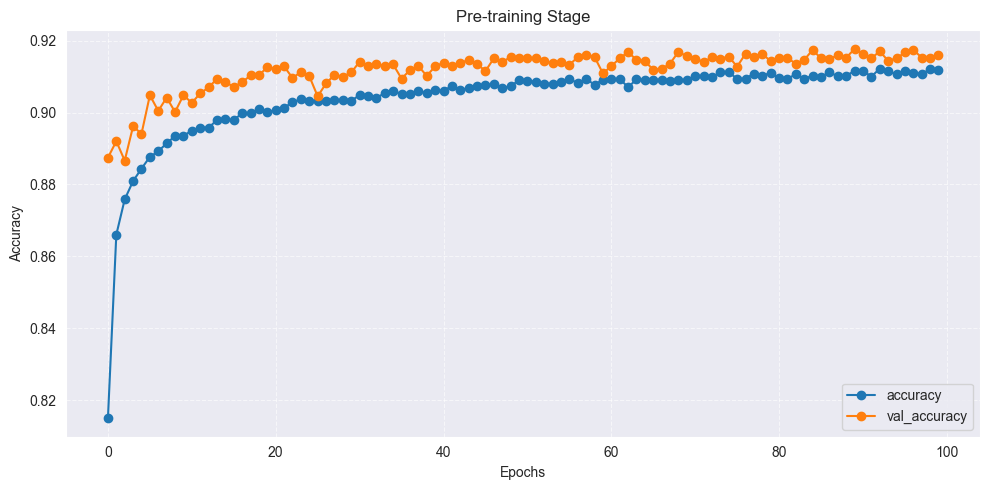

In [2]:
Threshold_K = 10  # 초기 학습 데이터
X_init, y_init, X_init_test, y_init_test = trainer.return_until_K_data(K=Threshold_K, train_ratio=0.8)
model_K10 = self_supervised_v1.build_model()  # 모델 생성 및 초기 학습
result = model_K10.fit(X_init, y_init, validation_data=(X_init_test, y_init_test), epochs=100, batch_size=64, verbose=0)
plot_result(result)

Dataset 1/58 - Session Exp_2025-05-27/E8331D05289A/
Dataset 2/58 - Session Exp_2025-06-18/E9AD0E7DCC2B/
Dataset 3/58 - Session Exp_2025-06-20-v1/E9AD0E7DCC2B/
Dataset 4/58 - Session Exp_2025-06-20-v2/E9AD0E7DCC2B/
Dataset 5/58 - Session Exp_2025-06-20-v3/E9AD0E7DCC2B/
Dataset 6/58 - Session Exp_2025-06-20-v4/E9AD0E7DCC2B/
Dataset 7/58 - Session Exp_2025-06-20-v5/E9AD0E7DCC2B/
Dataset 8/58 - Session Exp_2025-06-20-v6/E9AD0E7DCC2B/
Dataset 9/58 - Session Exp_2025-06-20-v7/E9AD0E7DCC2B/
Dataset 10/58 - Session Exp_2025-06-20-v8/E9AD0E7DCC2B/
Dataset 11/58 - Session Exp_2025-06-23-v1/E9AD0E7DCC2B/
Dataset 12/58 - Session Exp_2025-06-23-v2/E9AD0E7DCC2B/


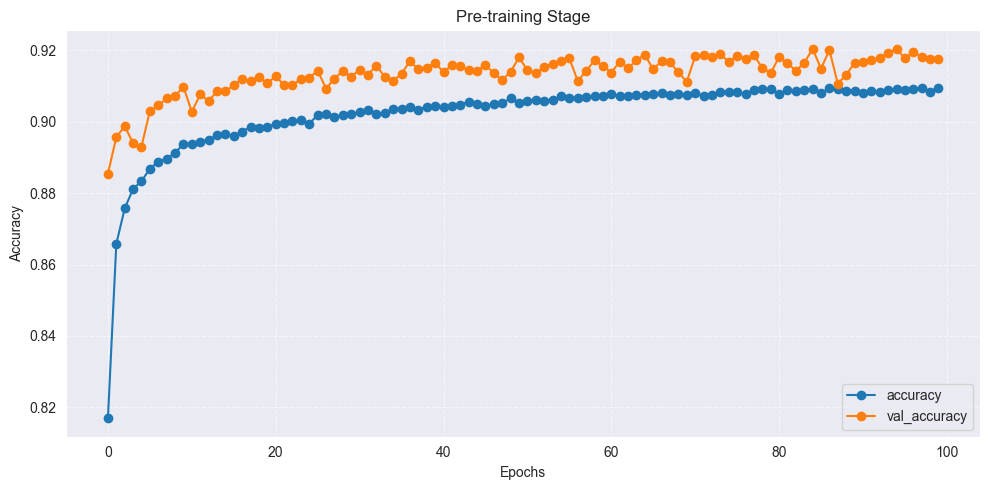

In [3]:
Threshold_K = 12  # 초기 학습 데이터
X_init, y_init, X_init_test, y_init_test = trainer.return_until_K_data(K=Threshold_K, train_ratio=0.8)
model_K12 = self_supervised_v1.build_model()  # 모델 생성 및 초기 학습
result = model_K12.fit(X_init, y_init, validation_data=(X_init_test, y_init_test), epochs=100, batch_size=64, verbose=0)
plot_result(result)

Dataset 1/58 - Session Exp_2025-05-27/E8331D05289A/
Dataset 2/58 - Session Exp_2025-06-18/E9AD0E7DCC2B/
Dataset 3/58 - Session Exp_2025-06-20-v1/E9AD0E7DCC2B/
Dataset 4/58 - Session Exp_2025-06-20-v2/E9AD0E7DCC2B/
Dataset 5/58 - Session Exp_2025-06-20-v3/E9AD0E7DCC2B/
Dataset 6/58 - Session Exp_2025-06-20-v4/E9AD0E7DCC2B/
Dataset 7/58 - Session Exp_2025-06-20-v5/E9AD0E7DCC2B/
Dataset 8/58 - Session Exp_2025-06-20-v6/E9AD0E7DCC2B/


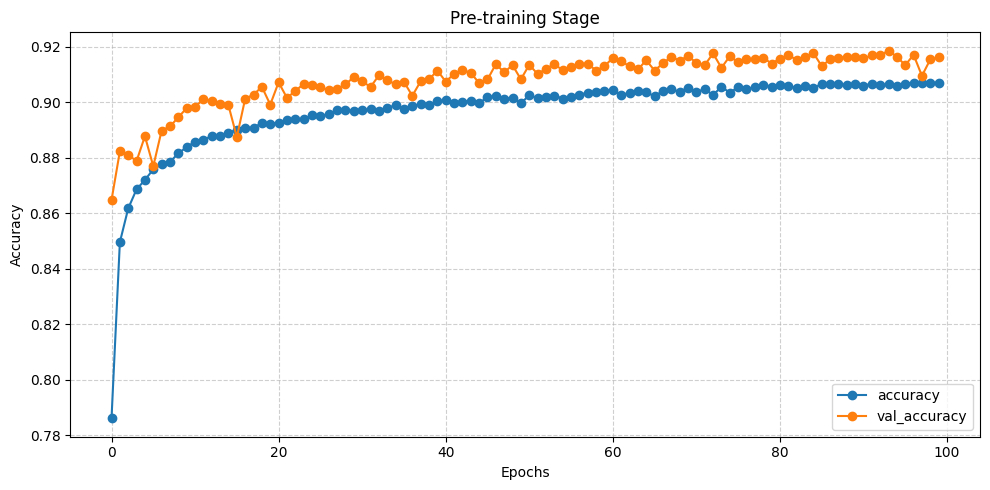

In [4]:
Threshold_K = 8  # 초기 학습 데이터
X_init, y_init, X_init_test, y_init_test = trainer.return_until_K_data(K=Threshold_K, train_ratio=0.8)
model_K8 = self_supervised_v1.build_model()  # 모델 생성 및 초기 학습
result = model_K8.fit(X_init, y_init, validation_data=(X_init_test, y_init_test), epochs=100, batch_size=64, verbose=0)
plot_result(result)

In [10]:
#model = model_K10

#model_K10.save('./model_K10.h5')
#model_K12.save('./model_K12.h5')

In [3]:
from tensorflow.keras.models import load_model

model = load_model('./model_K2.h5')
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
Threshold_K = 2


final_session = len(config.Info_sub_H)
# Accuracy 저장 리스트
Same_Session_Test_Acc, Next_Session_Test_Acc = [], []
Unseen_subject_acc_dict = {"C": [], "H2": [], "B": [], "X": []}
trainers_unseen = {
    "C": trainer_Carlson,
    "H2": trainer_Harold,
    "B": trainer_Brian,
    "X": trainer_Xianyu,
}

def evaluate_model(model, data, labels):
    return model.evaluate(data, labels, verbose=0)[1]


In [4]:
# 온라인 학습 루프
for session in range(Threshold_K, final_session-1):
    # 현재 세션 데이터
    X_train, _, X_test, y_test = trainer.return_K_th_data_only(K=session, train_ratio=0.8)

    # Pseudo-label 생성 및 온라인 업데이트
    pseudo_labels = self_supervised_v1.generate_pseudo_label(model, X_train)
    model = self_supervised_v1.online_update(model, X_train, pseudo_labels)

    # 같은 세션 테스트
    Same_Session_Test_Acc.append(evaluate_model(model, X_test, y_test))

    # 다음 세션 테스트
    next_X, next_y, _, _ = trainer.return_K_th_data_only(K=session + 1, train_ratio=0.8)
    Next_Session_Test_Acc.append(evaluate_model(model, next_X, next_y))

    # Unseen subject 테스트
    for key, trainer_sub in trainers_unseen.items():
        unseen_X, unseen_y, _, _ = trainer_sub.return_until_K_data(K=10, train_ratio=0.8)
        acc = evaluate_model(model, unseen_X, unseen_y)
        Unseen_subject_acc_dict[key].append(acc)

Returning K-th session data: Exp_2025-06-20-v1/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-06-20-v2/E9AD0E7DCC2B/
Dataset 1/18 - Session Exp_2025-06-30-v1/E9AD0E7DCC2B/
Dataset 2/18 - Session Exp_2025-06-30-v2/E9AD0E7DCC2B/
Dataset 3/18 - Session Exp_2025-07-09-v1/E9AD0E7DCC2B/
Dataset 4/18 - Session Exp_2025-07-09-v2/E9AD0E7DCC2B/
Dataset 5/18 - Session Exp_2025-07-10-v1/E9AD0E7DCC2B/
Dataset 6/18 - Session Exp_2025-07-10-v2/E9AD0E7DCC2B/
Dataset 7/18 - Session Exp_2025-07-11-v1/E9AD0E7DCC2B/
Dataset 8/18 - Session Exp_2025-07-11-v2/E9AD0E7DCC2B/
Dataset 9/18 - Session Exp_2025-07-16-v1/E9AD0E7DCC2B/
Dataset 10/18 - Session Exp_2025-07-16-v2/E9AD0E7DCC2B/
Dataset 1/18 - Session Exp_2025-07-09-v1/E9AD0E7DCC2B/
Dataset 2/18 - Session Exp_2025-07-09-v2/E9AD0E7DCC2B/
Dataset 3/18 - Session Exp_2025-07-10-v1/E9AD0E7DCC2B/
Dataset 4/18 - Session Exp_2025-07-10-v2/E9AD0E7DCC2B/
Dataset 5/18 - Session Exp_2025-07-11-v1/E9AD0E7DCC2B/
Dataset 6/18 - Session Exp_2025-07-11-v2/E9AD0E7DCC2

In [5]:
Same_Session_Test_Acc

[0.8434225916862488,
 0.890887975692749,
 0.8659726977348328,
 0.6680185198783875,
 0.7735739350318909,
 0.7220613956451416,
 0.7309703826904297,
 0.7273781895637512,
 0.7920560836791992,
 0.7254098653793335,
 0.7267407774925232,
 0.7349468469619751,
 0.8752186298370361,
 0.8557242751121521,
 0.8396281003952026,
 0.8103551864624023,
 0.8588921427726746,
 0.8610624670982361,
 0.7662790417671204,
 0.8045243620872498,
 0.8880952596664429,
 0.8684820532798767,
 0.9205607771873474,
 0.8929610252380371,
 0.881936252117157,
 0.8853985071182251,
 0.8929845690727234,
 0.9297012090682983,
 0.875217616558075,
 0.8793503642082214,
 0.8770301342010498,
 0.890307605266571,
 0.9116792678833008,
 0.878190279006958,
 0.8446376919746399,
 0.885478138923645,
 0.8887601494789124,
 0.8841922283172607,
 0.8690614104270935,
 0.8797909617424011,
 0.8778228163719177,
 0.9088798761367798,
 0.8828985691070557,
 0.8694137930870056,
 0.8812282681465149,
 0.9216027855873108,
 0.9112529158592224,
 0.9118329286575317

In [6]:
Next_Session_Test_Acc

[0.8814223408699036,
 0.8614634275436401,
 0.6921071410179138,
 0.7884167432785034,
 0.7112044095993042,
 0.7425541281700134,
 0.7336909174919128,
 0.7879982590675354,
 0.7241328954696655,
 0.7355178594589233,
 0.7421067953109741,
 0.8739434480667114,
 0.8528467416763306,
 0.8500653505325317,
 0.8191121220588684,
 0.8627879619598389,
 0.8557047247886658,
 0.7757593393325806,
 0.806872546672821,
 0.8727489113807678,
 0.863991916179657,
 0.9227285981178284,
 0.8939944505691528,
 0.8810858726501465,
 0.8757998943328857,
 0.8797919750213623,
 0.9165202379226685,
 0.8692307472229004,
 0.8740031719207764,
 0.8708321452140808,
 0.8793904185295105,
 0.8987360000610352,
 0.8717725276947021,
 0.8562318682670593,
 0.8802006244659424,
 0.8916569948196411,
 0.8827446699142456,
 0.8715423345565796,
 0.8812772035598755,
 0.8941959738731384,
 0.9030901193618774,
 0.884782612323761,
 0.8798781633377075,
 0.8822422027587891,
 0.9210106134414673,
 0.9126777052879333,
 0.9141780138015747,
 0.9063540101051

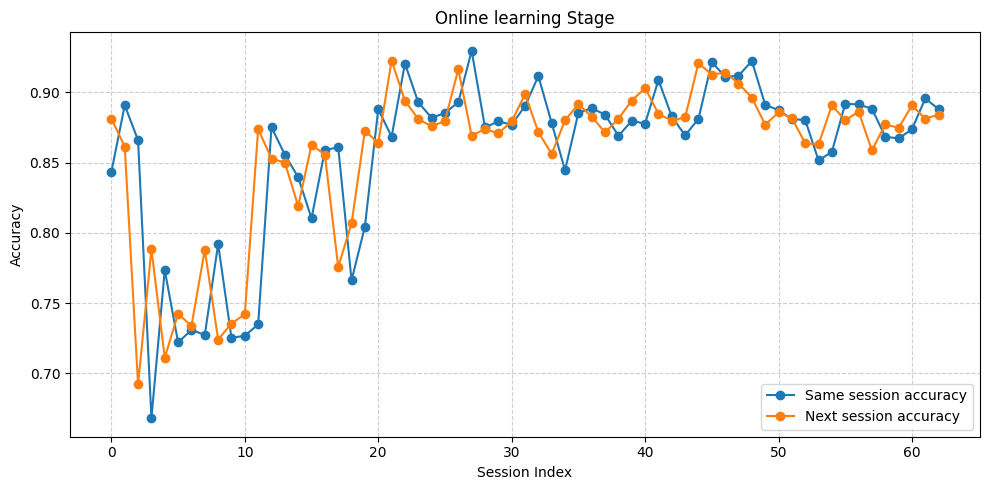

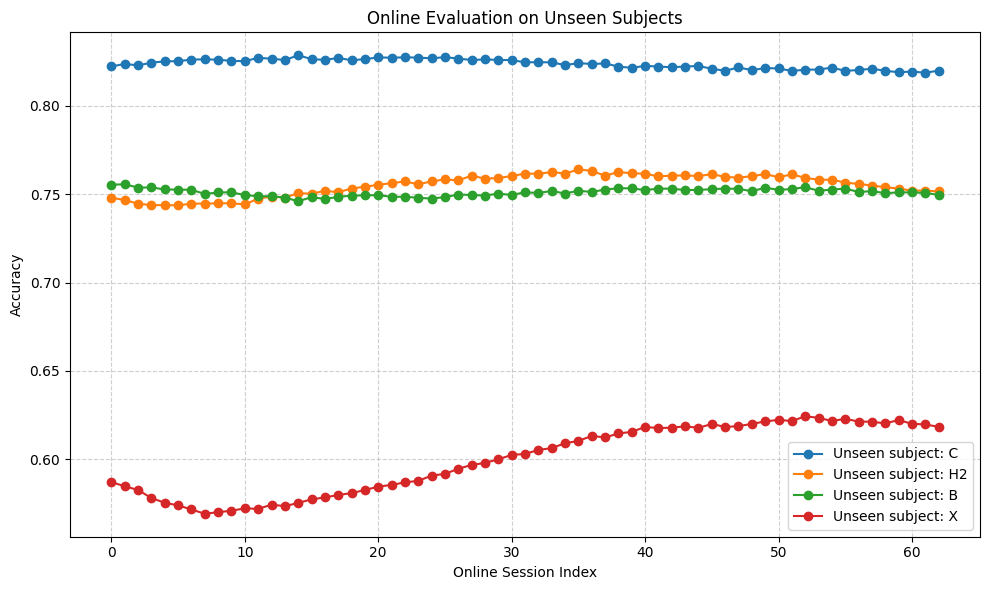

In [7]:
#K2
plt.figure(figsize=(10, 5))
plt.plot(Same_Session_Test_Acc, label='Same session accuracy', marker='o')
plt.plot(Next_Session_Test_Acc, label='Next session accuracy', marker='o')
plt.title('Online learning Stage')
plt.xlabel('Session Index')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for subject, acc_list in Unseen_subject_acc_dict.items():
    plt.plot(acc_list, label=f'Unseen subject: {subject}', marker='o')

plt.title('Online Evaluation on Unseen Subjects')
plt.xlabel('Online Session Index')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

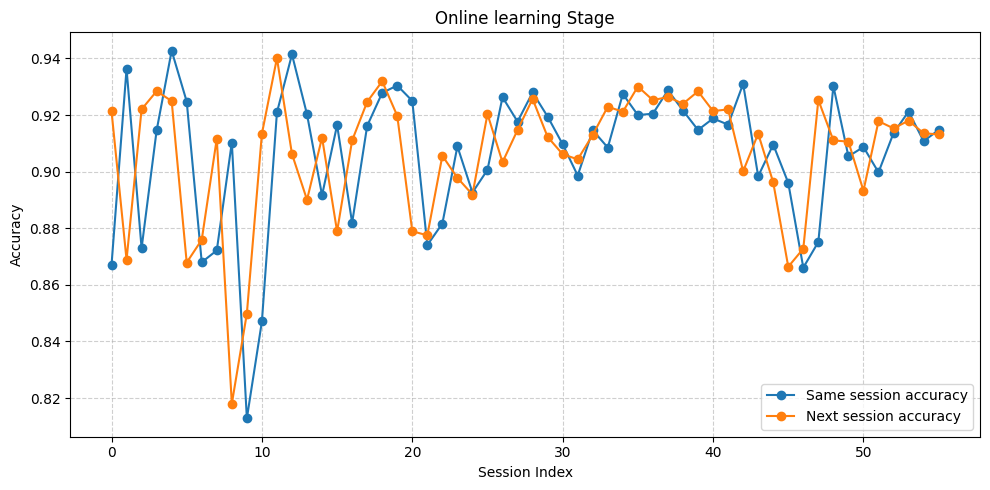

In [17]:
#K10
plt.figure(figsize=(10, 5))
plt.plot(Same_Session_Test_Acc, label='Same session accuracy', marker='o')
plt.plot(Next_Session_Test_Acc, label='Next session accuracy', marker='o')
plt.title('Online learning Stage')
plt.xlabel('Session Index')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

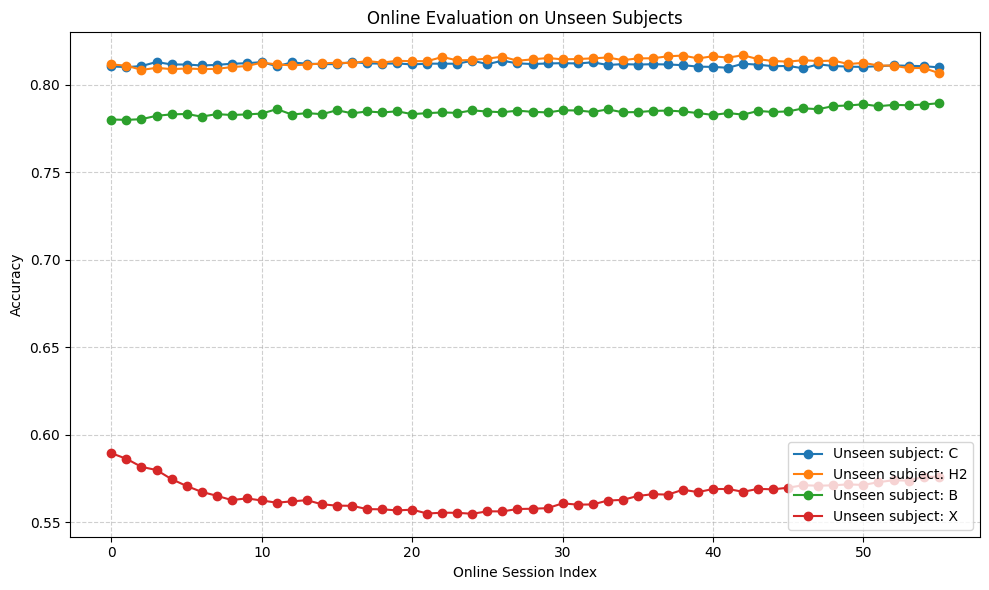

In [18]:
plt.figure(figsize=(10, 6))
for subject, acc_list in Unseen_subject_acc_dict.items():
    plt.plot(acc_list, label=f'Unseen subject: {subject}', marker='o')

plt.title('Online Evaluation on Unseen Subjects')
plt.xlabel('Online Session Index')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [8]:
model = load_model('./model_K4.h5')
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
Threshold_K = 4


final_session = len(config.Info_sub_H)
# Accuracy 저장 리스트
Same_Session_Test_Acc, Next_Session_Test_Acc = [], []
Unseen_subject_acc_dict = {"C": [], "H2": [], "B": [], "X": []}
trainers_unseen = {
    "C": trainer_Carlson,
    "H2": trainer_Harold,
    "B": trainer_Brian,
    "X": trainer_Xianyu,
}

for session in range(Threshold_K, final_session-1):
    X_train, _, X_test, y_test = trainer.return_K_th_data_only(K=session, train_ratio=0.8)

    pseudo_labels = self_supervised_v1.generate_pseudo_label(model, X_train)
    model = self_supervised_v1.online_update(model, X_train, pseudo_labels)

    Same_Session_Test_Acc.append(evaluate_model(model, X_test, y_test))
    next_X, next_y, _, _ = trainer.return_K_th_data_only(K=session + 1, train_ratio=0.8)
    Next_Session_Test_Acc.append(evaluate_model(model, next_X, next_y))

    for key, trainer_sub in trainers_unseen.items():
        unseen_X, unseen_y, _, _ = trainer_sub.return_until_K_data(K=10, train_ratio=0.8)
        acc = evaluate_model(model, unseen_X, unseen_y)
        Unseen_subject_acc_dict[key].append(acc)

Returning K-th session data: Exp_2025-06-20-v3/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-06-20-v4/E9AD0E7DCC2B/
Dataset 1/18 - Session Exp_2025-06-30-v1/E9AD0E7DCC2B/
Dataset 2/18 - Session Exp_2025-06-30-v2/E9AD0E7DCC2B/
Dataset 3/18 - Session Exp_2025-07-09-v1/E9AD0E7DCC2B/
Dataset 4/18 - Session Exp_2025-07-09-v2/E9AD0E7DCC2B/
Dataset 5/18 - Session Exp_2025-07-10-v1/E9AD0E7DCC2B/
Dataset 6/18 - Session Exp_2025-07-10-v2/E9AD0E7DCC2B/
Dataset 7/18 - Session Exp_2025-07-11-v1/E9AD0E7DCC2B/
Dataset 8/18 - Session Exp_2025-07-11-v2/E9AD0E7DCC2B/
Dataset 9/18 - Session Exp_2025-07-16-v1/E9AD0E7DCC2B/
Dataset 10/18 - Session Exp_2025-07-16-v2/E9AD0E7DCC2B/
Dataset 1/18 - Session Exp_2025-07-09-v1/E9AD0E7DCC2B/
Dataset 2/18 - Session Exp_2025-07-09-v2/E9AD0E7DCC2B/
Dataset 3/18 - Session Exp_2025-07-10-v1/E9AD0E7DCC2B/
Dataset 4/18 - Session Exp_2025-07-10-v2/E9AD0E7DCC2B/
Dataset 5/18 - Session Exp_2025-07-11-v1/E9AD0E7DCC2B/
Dataset 6/18 - Session Exp_2025-07-11-v2/E9AD0E7DCC2

In [9]:
Same_Session_Test_Acc

[0.8998048305511475,
 0.7537659406661987,
 0.793364405632019,
 0.7156919240951538,
 0.7176060676574707,
 0.7459396719932556,
 0.764018714427948,
 0.7101873755455017,
 0.7431246638298035,
 0.7461629509925842,
 0.8862974047660828,
 0.8393691778182983,
 0.800116240978241,
 0.7947019934654236,
 0.8011661767959595,
 0.8458844423294067,
 0.7715116143226624,
 0.8062645196914673,
 0.8583333492279053,
 0.8702201843261719,
 0.8855140209197998,
 0.8819080591201782,
 0.8317591547966003,
 0.8266434073448181,
 0.8495838046073914,
 0.8916227221488953,
 0.865351140499115,
 0.8341067433357239,
 0.8578886389732361,
 0.864770770072937,
 0.8547356128692627,
 0.8712297081947327,
 0.8318840861320496,
 0.8707202076911926,
 0.8783314228057861,
 0.8795599341392517,
 0.8597913980484009,
 0.8908246159553528,
 0.8812970519065857,
 0.8961114287376404,
 0.8927536010742188,
 0.890887975692749,
 0.8684820532798767,
 0.9285714030265808,
 0.9095127582550049,
 0.9222737550735474,
 0.9050376415252686,
 0.8988895416259766

In [20]:
Next_Session_Test_Acc

[0.7352344989776611,
 0.7209065556526184,
 0.7244128584861755,
 0.7412760853767395,
 0.7582321166992188,
 0.7469280362129211,
 0.7555326223373413,
 0.8564558625221252,
 0.8037956357002258,
 0.8181025981903076,
 0.8203160166740417,
 0.8200641870498657,
 0.839072048664093,
 0.7961052060127258,
 0.822096586227417,
 0.8337550163269043,
 0.8548667430877686,
 0.8794916868209839,
 0.8665115833282471,
 0.7797285318374634,
 0.790285050868988,
 0.8402674794197083,
 0.8851786851882935,
 0.8089985251426697,
 0.8335508108139038,
 0.8373441696166992,
 0.8481857776641846,
 0.852389931678772,
 0.8796054720878601,
 0.8352174162864685,
 0.8800531029701233,
 0.8841251730918884,
 0.8752171397209167,
 0.854163646697998,
 0.8706821203231812,
 0.8818931579589844,
 0.8922094702720642,
 0.8831884264945984,
 0.8952560424804688,
 0.8806489109992981,
 0.9048932790756226,
 0.9076008200645447,
 0.906639575958252,
 0.8982486724853516,
 0.8926380276679993,
 0.8753265738487244,
 0.8832366466522217,
 0.8773584961891174

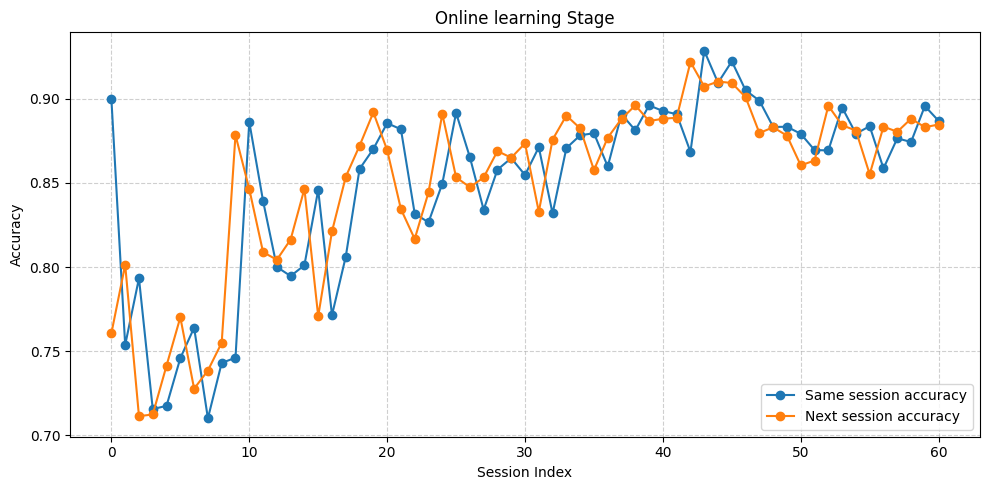

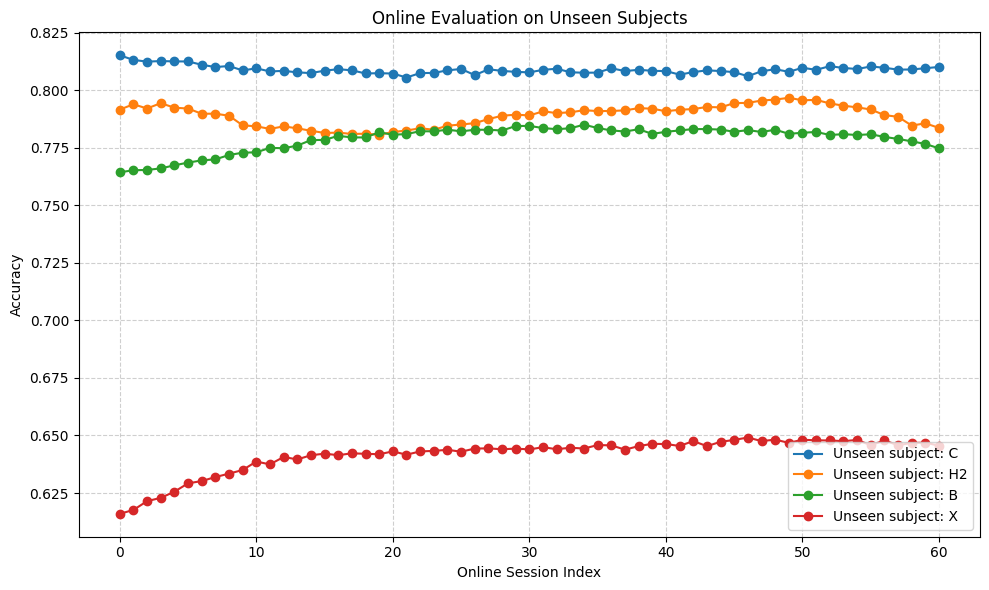

In [11]:
#K4
plt.figure(figsize=(10, 5))
plt.plot(Same_Session_Test_Acc, label='Same session accuracy', marker='o')
plt.plot(Next_Session_Test_Acc, label='Next session accuracy', marker='o')
plt.title('Online learning Stage')
plt.xlabel('Session Index')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for subject, acc_list in Unseen_subject_acc_dict.items():
    plt.plot(acc_list, label=f'Unseen subject: {subject}', marker='o')

plt.title('Online Evaluation on Unseen Subjects')
plt.xlabel('Online Session Index')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [12]:
model = load_model('./model_K1.h5')
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
Threshold_K = 1


final_session = len(config.Info_sub_H)
# Accuracy 저장 리스트
Same_Session_Test_Acc, Next_Session_Test_Acc = [], []
Unseen_subject_acc_dict = {"C": [], "H2": [], "B": [], "X": []}
trainers_unseen = {
    "C": trainer_Carlson,
    "H2": trainer_Harold,
    "B": trainer_Brian,
    "X": trainer_Xianyu,
}

for session in range(Threshold_K, final_session-1):
    X_train, _, X_test, y_test = trainer.return_K_th_data_only(K=session, train_ratio=0.8)

    pseudo_labels = self_supervised_v1.generate_pseudo_label(model, X_train)
    model = self_supervised_v1.online_update(model, X_train, pseudo_labels)

    Same_Session_Test_Acc.append(evaluate_model(model, X_test, y_test))
    next_X, next_y, _, _ = trainer.return_K_th_data_only(K=session + 1, train_ratio=0.8)
    Next_Session_Test_Acc.append(evaluate_model(model, next_X, next_y))

    for key, trainer_sub in trainers_unseen.items():
        unseen_X, unseen_y, _, _ = trainer_sub.return_until_K_data(K=10, train_ratio=0.8)
        acc = evaluate_model(model, unseen_X, unseen_y)
        Unseen_subject_acc_dict[key].append(acc)

Returning K-th session data: Exp_2025-06-18/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-06-20-v1/E9AD0E7DCC2B/
Dataset 1/18 - Session Exp_2025-06-30-v1/E9AD0E7DCC2B/
Dataset 2/18 - Session Exp_2025-06-30-v2/E9AD0E7DCC2B/
Dataset 3/18 - Session Exp_2025-07-09-v1/E9AD0E7DCC2B/
Dataset 4/18 - Session Exp_2025-07-09-v2/E9AD0E7DCC2B/
Dataset 5/18 - Session Exp_2025-07-10-v1/E9AD0E7DCC2B/
Dataset 6/18 - Session Exp_2025-07-10-v2/E9AD0E7DCC2B/
Dataset 7/18 - Session Exp_2025-07-11-v1/E9AD0E7DCC2B/
Dataset 8/18 - Session Exp_2025-07-11-v2/E9AD0E7DCC2B/
Dataset 9/18 - Session Exp_2025-07-16-v1/E9AD0E7DCC2B/
Dataset 10/18 - Session Exp_2025-07-16-v2/E9AD0E7DCC2B/
Dataset 1/18 - Session Exp_2025-07-09-v1/E9AD0E7DCC2B/
Dataset 2/18 - Session Exp_2025-07-09-v2/E9AD0E7DCC2B/
Dataset 3/18 - Session Exp_2025-07-10-v1/E9AD0E7DCC2B/
Dataset 4/18 - Session Exp_2025-07-10-v2/E9AD0E7DCC2B/
Dataset 5/18 - Session Exp_2025-07-11-v1/E9AD0E7DCC2B/
Dataset 6/18 - Session Exp_2025-07-11-v2/E9AD0E7DCC2B/


In [13]:
Same_Session_Test_Acc

[0.8486078977584839,
 0.7334109544754028,
 0.8583865165710449,
 0.7924528121948242,
 0.6784473061561584,
 0.7462165355682373,
 0.7562246918678284,
 0.6972690224647522,
 0.6821345686912537,
 0.7009345889091492,
 0.671545684337616,
 0.6752486824989319,
 0.6918535828590393,
 0.7795918583869934,
 0.77862149477005,
 0.8221964240074158,
 0.8374473452568054,
 0.783090353012085,
 0.8219497799873352,
 0.7662790417671204,
 0.796403706073761,
 0.8297619223594666,
 0.8725376725196838,
 0.8352803587913513,
 0.8696916699409485,
 0.7573789954185486,
 0.7958115339279175,
 0.8329370021820068,
 0.8506151437759399,
 0.7690075635910034,
 0.8306264281272888,
 0.8120649456977844,
 0.839814305305481,
 0.8582219481468201,
 0.8387470841407776,
 0.8371014595031738,
 0.8648170232772827,
 0.8818076252937317,
 0.8760856986045837,
 0.8487833142280579,
 0.8658536672592163,
 0.8998262882232666,
 0.8949506878852844,
 0.8933333158493042,
 0.875217616558075,
 0.8690614104270935,
 0.8989546895027161,
 0.8897911906242371,

In [14]:
Next_Session_Test_Acc

[0.7318777441978455,
 0.8579100370407104,
 0.7931707501411438,
 0.6868935823440552,
 0.7454889416694641,
 0.7485523819923401,
 0.6872003674507141,
 0.6777326464653015,
 0.7234632968902588,
 0.6828625798225403,
 0.6748098134994507,
 0.6885511875152588,
 0.7822791934013367,
 0.7633576393127441,
 0.8183931708335876,
 0.8356659412384033,
 0.7839019894599915,
 0.8206886649131775,
 0.7859323024749756,
 0.7986080646514893,
 0.8211043477058411,
 0.8744206428527832,
 0.8404908180236816,
 0.8711647391319275,
 0.7776630520820618,
 0.7974112629890442,
 0.8283804059028625,
 0.8476859927177429,
 0.7640057802200317,
 0.8261563181877136,
 0.8122644424438477,
 0.8297532796859741,
 0.8551503419876099,
 0.8604583740234375,
 0.8371014595031738,
 0.8664798140525818,
 0.8776071667671204,
 0.8801389932632446,
 0.8485155701637268,
 0.8699564337730408,
 0.8862353563308716,
 0.9014942646026611,
 0.8897101283073425,
 0.8794429302215576,
 0.8864426612854004,
 0.8910991549491882,
 0.8843922019004822,
 0.8962017893

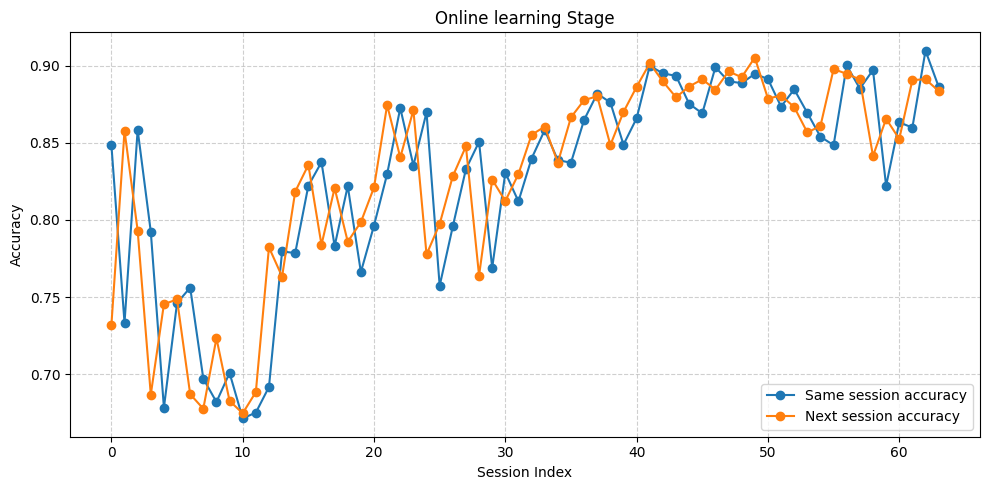

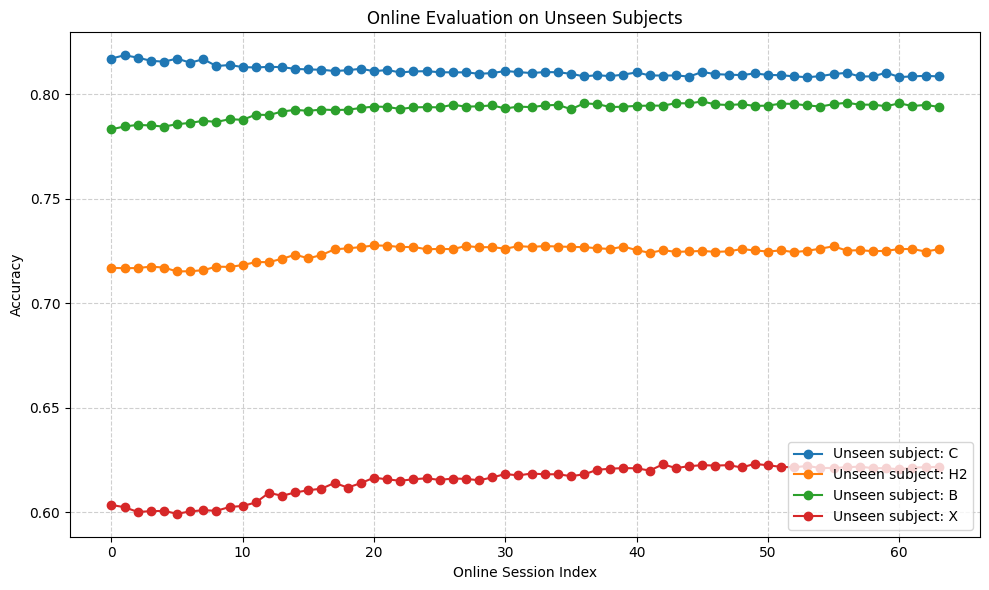

In [15]:
#K4
plt.figure(figsize=(10, 5))
plt.plot(Same_Session_Test_Acc, label='Same session accuracy', marker='o')
plt.plot(Next_Session_Test_Acc, label='Next session accuracy', marker='o')
plt.title('Online learning Stage')
plt.xlabel('Session Index')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for subject, acc_list in Unseen_subject_acc_dict.items():
    plt.plot(acc_list, label=f'Unseen subject: {subject}', marker='o')

plt.title('Online Evaluation on Unseen Subjects')
plt.xlabel('Online Session Index')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [16]:
model = load_model('./model_K6.h5')
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
Threshold_K = 6


final_session = len(config.Info_sub_H)
# Accuracy 저장 리스트
Same_Session_Test_Acc, Next_Session_Test_Acc = [], []
Unseen_subject_acc_dict = {"C": [], "H2": [], "B": [], "X": []}
trainers_unseen = {
    "C": trainer_Carlson,
    "H2": trainer_Harold,
    "B": trainer_Brian,
    "X": trainer_Xianyu,
}

for session in range(Threshold_K, final_session-1):
    X_train, _, X_test, y_test = trainer.return_K_th_data_only(K=session, train_ratio=0.8)

    pseudo_labels = self_supervised_v1.generate_pseudo_label(model, X_train)
    model = self_supervised_v1.online_update(model, X_train, pseudo_labels)

    Same_Session_Test_Acc.append(evaluate_model(model, X_test, y_test))
    next_X, next_y, _, _ = trainer.return_K_th_data_only(K=session + 1, train_ratio=0.8)
    Next_Session_Test_Acc.append(evaluate_model(model, next_X, next_y))

    for key, trainer_sub in trainers_unseen.items():
        unseen_X, unseen_y, _, _ = trainer_sub.return_until_K_data(K=10, train_ratio=0.8)
        acc = evaluate_model(model, unseen_X, unseen_y)
        Unseen_subject_acc_dict[key].append(acc)

Returning K-th session data: Exp_2025-06-20-v5/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-06-20-v6/E9AD0E7DCC2B/
Dataset 1/18 - Session Exp_2025-06-30-v1/E9AD0E7DCC2B/
Dataset 2/18 - Session Exp_2025-06-30-v2/E9AD0E7DCC2B/
Dataset 3/18 - Session Exp_2025-07-09-v1/E9AD0E7DCC2B/
Dataset 4/18 - Session Exp_2025-07-09-v2/E9AD0E7DCC2B/
Dataset 5/18 - Session Exp_2025-07-10-v1/E9AD0E7DCC2B/
Dataset 6/18 - Session Exp_2025-07-10-v2/E9AD0E7DCC2B/
Dataset 7/18 - Session Exp_2025-07-11-v1/E9AD0E7DCC2B/
Dataset 8/18 - Session Exp_2025-07-11-v2/E9AD0E7DCC2B/
Dataset 9/18 - Session Exp_2025-07-16-v1/E9AD0E7DCC2B/
Dataset 10/18 - Session Exp_2025-07-16-v2/E9AD0E7DCC2B/
Dataset 1/18 - Session Exp_2025-07-09-v1/E9AD0E7DCC2B/
Dataset 2/18 - Session Exp_2025-07-09-v2/E9AD0E7DCC2B/
Dataset 3/18 - Session Exp_2025-07-10-v1/E9AD0E7DCC2B/
Dataset 4/18 - Session Exp_2025-07-10-v2/E9AD0E7DCC2B/
Dataset 5/18 - Session Exp_2025-07-11-v1/E9AD0E7DCC2B/
Dataset 6/18 - Session Exp_2025-07-11-v2/E9AD0E7DCC2

In [17]:
Same_Session_Test_Acc

[0.7409778833389282,
 0.7382744550704956,
 0.7141196727752686,
 0.7314385175704956,
 0.7464953064918518,
 0.7570257782936096,
 0.7478057146072388,
 0.7644628286361694,
 0.8559767007827759,
 0.7920560836791992,
 0.8070889115333557,
 0.8175797462463379,
 0.8157434463500977,
 0.8429655432701111,
 0.789534866809845,
 0.8242459297180176,
 0.838690459728241,
 0.8563151955604553,
 0.8685747385025024,
 0.8551483154296875,
 0.7857142686843872,
 0.7882489562034607,
 0.840665876865387,
 0.8816637396812439,
 0.8160185813903809,
 0.8364269137382507,
 0.8387470841407776,
 0.8450376987457275,
 0.8663567900657654,
 0.8741299510002136,
 0.8475362062454224,
 0.8648170232772827,
 0.8887601494789124,
 0.8917197585105896,
 0.8464658260345459,
 0.8792102336883545,
 0.8766647577285767,
 0.8810214996337891,
 0.879420280456543,
 0.8978525996208191,
 0.8725376725196838,
 0.904181182384491,
 0.9025521874427795,
 0.9077726006507874,
 0.8980891704559326,
 0.8942139148712158,
 0.8815330862998962,
 0.881023228168487

In [18]:
Next_Session_Test_Acc

[0.7352344989776611,
 0.7209065556526184,
 0.7244128584861755,
 0.7412760853767395,
 0.7582321166992188,
 0.7469280362129211,
 0.7555326223373413,
 0.8564558625221252,
 0.8037956357002258,
 0.8181025981903076,
 0.8203160166740417,
 0.8200641870498657,
 0.839072048664093,
 0.7961052060127258,
 0.822096586227417,
 0.8337550163269043,
 0.8548667430877686,
 0.8794916868209839,
 0.8665115833282471,
 0.7797285318374634,
 0.790285050868988,
 0.8402674794197083,
 0.8851786851882935,
 0.8089985251426697,
 0.8335508108139038,
 0.8373441696166992,
 0.8481857776641846,
 0.852389931678772,
 0.8796054720878601,
 0.8352174162864685,
 0.8800531029701233,
 0.8841251730918884,
 0.8752171397209167,
 0.854163646697998,
 0.8706821203231812,
 0.8818931579589844,
 0.8922094702720642,
 0.8831884264945984,
 0.8952560424804688,
 0.8806489109992981,
 0.9048932790756226,
 0.9076008200645447,
 0.906639575958252,
 0.8982486724853516,
 0.8926380276679993,
 0.8753265738487244,
 0.8832366466522217,
 0.8773584961891174

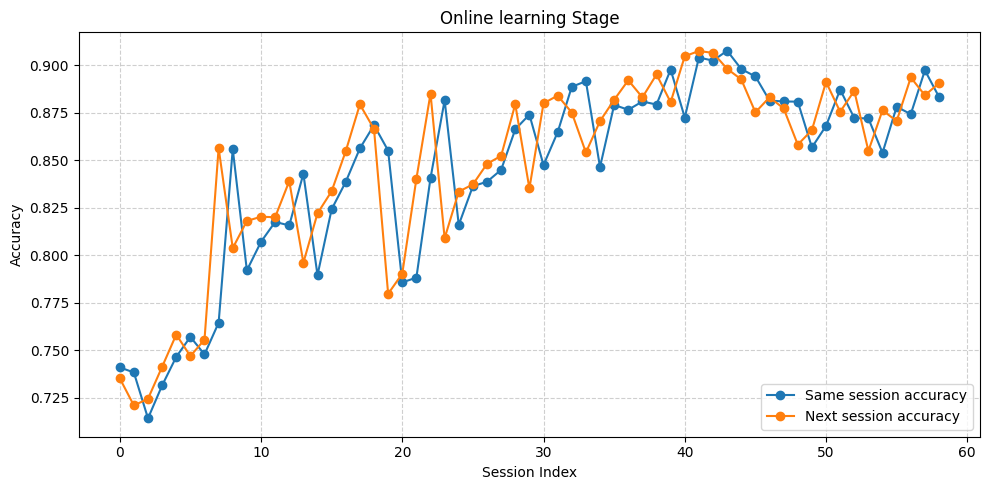

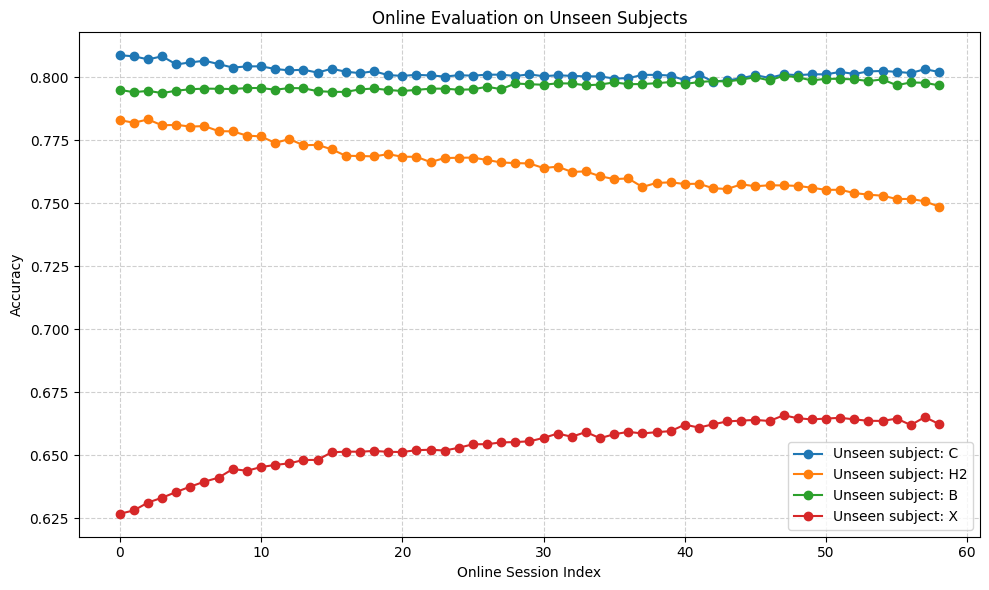

In [19]:
#K4
plt.figure(figsize=(10, 5))
plt.plot(Same_Session_Test_Acc, label='Same session accuracy', marker='o')
plt.plot(Next_Session_Test_Acc, label='Next session accuracy', marker='o')
plt.title('Online learning Stage')
plt.xlabel('Session Index')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for subject, acc_list in Unseen_subject_acc_dict.items():
    plt.plot(acc_list, label=f'Unseen subject: {subject}', marker='o')

plt.title('Online Evaluation on Unseen Subjects')
plt.xlabel('Online Session Index')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()